In [64]:
from pyscf.agf2.aux_space import GreensFunction
from pyscf.data.nist import HARTREE2EV
from pyscf import gto
from gmtkn import GW100 as systems
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json

ref = "ccsd_t"

plt.style.use('seaborn-talk')
plt.rc('axes', facecolor='whitesmoke')
plt.rc('figure', facecolor='white')
plt.rc('lines', markeredgecolor='k', markeredgewidth=1.0)
%matplotlib inline

In [2]:
def load_chk(chkfile):
    with h5py.File(chkfile, "r") as f:
        e = np.array(f["gf"]["energy"])
        c = np.array(f["gf"]["coupling"])
        mu = np.array(f["gf"]["chempot"]).ravel()[0]
        gf = GreensFunction(e, c, chempot=mu)
        return gf

with open("data/gw100_3c70297.json", "r") as f:
    gw100 = json.load(f)

ns = (0, 1, 2, 5)
xcs = {
    "diag": "data/diag_ag0w0_%d_df_def2-tzvpp_%s.chk",
    "hf": "data/ag0w0_%d_df_def2-tzvpp_%s.chk",
    "pbe": "data/ag0w0_%d_df_pbe_def2-tzvpp_%s.chk",
    "b3lyp": "data/ag0w0_%d_df_b3lyp_def2-tzvpp_%s.chk",
}
labels = {
    "diag": "Diag-A$G_0W_0$@HF",
    "hf": "A$G_0W_0$@HF",
    "pbe": "A$G_0W_0$@PBE",
    "b3lyp": "A$G_0W_0$@B3LYP",
    "experiment": "Experiment",
    "ccsd_t": "CCSD(T)",
    "g0w0_hf": "$G_0W_0$@HF",
    "g0w0_pbe": "$G_0W_0$@PBE",
}
ref_methods = ("experiment", "ccsd_t", "g0w0_hf", "hf", "g0w0_pbe", "pbe")
names = sorted(list(systems.keys()))
homos = {xc: {n: [] for n in ns} for xc in xcs.keys()}
lumos = {xc: {n: [] for n in ns} for xc in xcs.keys()}
homo_weights = {xc: {n: [] for n in ns} for xc in xcs.keys()}
lumo_weights = {xc: {n: [] for n in ns} for xc in xcs.keys()}
ref_homos = {ref: [] for ref in ref_methods}
ref_lumos = {ref: [] for ref in ref_methods}

# Get the data:
for key in names:
    mol = gto.M(
            atom=zip(systems[key]['atoms'], systems[key]['coords']),
            charge=systems[key]['charge'],
            spin=systems[key]['spin'],
            basis="def2-tzvpp",
            ecp={'Rb':"def2-tzvpp", 'Ag':"def2-tzvpp", 'I':"def2-tzvpp", 'Cs':"def2-tzvpp", 'Au':"def2-tzvpp", 'Xe':"def2-tzvpp"},
            verbose=0,
    )
    nocc = mol.nelectron // 2

    for xc in xcs.keys():
        for n in ns:
            try:
                gf = load_chk(xcs[xc] % (n, key))
            except:
                homos[xc][n].append(np.nan)
                homo_weights[xc][n].append(np.nan)
                lumos[xc][n].append(np.nan)
                lumo_weights[xc][n].append(np.nan)
                continue

            # homo
            gf_occ = gf.get_occupied()
            arg = np.argmax(gf_occ.coupling[nocc-1]**2)
            homos[xc][n].append(-gf_occ.energy[arg] * HARTREE2EV)
            homo_weights[xc][n].append(gf_occ.coupling[nocc-1, arg]**2)

            # lumo
            gf_vir = gf.get_virtual()
            arg = np.argmax(gf_vir.coupling[nocc]**2)
            lumos[xc][n].append(gf_vir.energy[arg] * HARTREE2EV)
            lumo_weights[xc][n].append(gf_vir.coupling[nocc, arg]**2)

    ref_homos["experiment"].append(np.float64(gw100["systems"][key]["experiment"].get("e_ip", np.nan)) * HARTREE2EV)
    ref_lumos["experiment"].append(np.float64(gw100["systems"][key]["experiment"].get("e_ea", np.nan)) * HARTREE2EV)
    for method in ref_homos.keys():
        if method != "experiment":
            ref_homos[method].append(np.float64(gw100["systems"][key]["def2-tzvpp"][method].get("e_ip", np.nan)) * HARTREE2EV)
            ref_lumos[method].append(np.float64(gw100["systems"][key]["def2-tzvpp"][method].get("e_ea", np.nan)) * HARTREE2EV)

            0    1    2    5
   b3lyp  101  101  101  101
    diag  102  102  102  102
      hf  102  102  102  102
     pbe  102  102  102  102


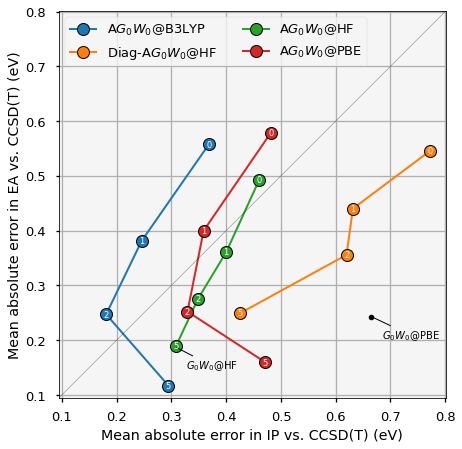

In [3]:
# Plot scatter
fig, ax = plt.subplots(figsize=(6.4, 6.4))
ax.set_aspect(1.0)
print((" " * 9) + " ".join(["%4d" % n for n in ns]))
for m in ("g0w0_hf", "g0w0_pbe"):
    ip = np.nanmean(np.abs(np.array(ref_homos[ref], dtype=np.float64) - np.array(ref_homos[m], dtype=np.float64)))
    ea = np.nanmean(np.abs(np.array(ref_lumos[ref], dtype=np.float64) - np.array(ref_lumos[m], dtype=np.float64)))
    ax.plot(ip, ea, "k.")
    ax.annotate(labels[m], (ip, ea), xycoords="data", xytext=(ip+0.02, ea-0.04), textcoords="data", arrowprops=dict(arrowstyle="-", color="k", lw=1.0))
for i, xc in enumerate(sorted(list(xcs.keys()))):
    ips = [np.array(ref_homos[ref], dtype=np.float64) - np.array(homos[xc][n], dtype=np.float64) for n in ns]
    eas = [np.array(ref_lumos[ref], dtype=np.float64) - np.array(lumos[xc][n], dtype=np.float64) for n in ns]
    ip = [np.nanmean(np.abs(x)) for x in ips]
    ea = [np.nanmean(np.abs(x)) for x in eas]
    ax.plot(ip, ea, "C%do-"%i, label=labels[xc], mec="black", ms=12, lw=2)
    for j, (x, y) in enumerate(zip(ip, ea)):
        ax.text(x, y, str(ns[j]), ha="center", va="center", c="white", fontsize="small")
    print(("%8s " % xc) + " ".join(["%4d" % np.sum(np.isfinite(np.subtract(x, y))) for x, y in zip(ips, eas)]))
lim = (min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]))
ax.plot(lim, lim, "k-", alpha=0.5, lw=0.5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_xlabel("Mean absolute error in IP vs. %s (eV)" % labels[ref])
ax.set_ylabel("Mean absolute error in EA vs. %s (eV)" % labels[ref])
ax.grid()
ax.legend(ncol=2)
plt.tight_layout()
plt.show()

0 0 0.6094250058200293 0.5788565870371328
1 0 0.44990721409372153 0.384960855972371
2 0 0.35544786030345593 0.26350692309134505
3 0 0.2999662916953725 0.3266017083691226
0 1 0.48324096736735567 0.5749881240732264
1 1 0.4097480889343889 0.48827369405917015
2 1 0.42102265202340605 0.466418655525083
3 1 0.3083014588212666 0.37759324418211704
0 2 0.3930980069205217 0.4716181815527223
1 2 0.27559589942532425 0.36224235766450236
2 2 0.23058549687865526 0.32923002295208975
3 2 0.23000912841707227 0.32701753239671344
0 3 0.77101761370313 0.9009197075552714
1 3 0.6146862249772117 0.7370778790167325
2 3 0.5190072300604953 0.5817969261586176
3 3 0.47552406318464774 0.525381111370091


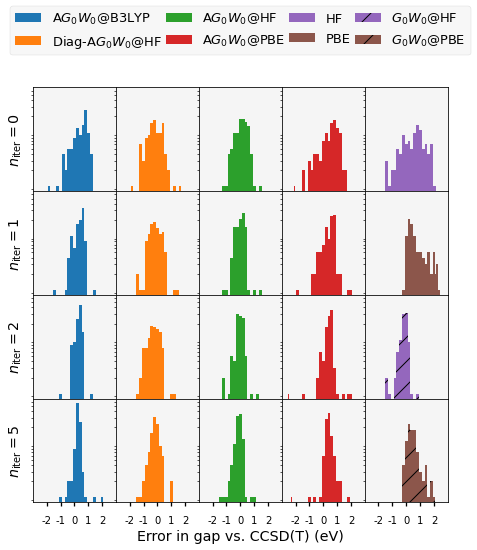

In [70]:
# Plot histograms
bins = np.linspace(-5.0, 5.0, 50)
fig, axs = plt.subplots(facecolor='w', nrows=4, ncols=5, sharex=True, sharey=True, figsize=(6.4, 6.4))
plt.subplots_adjust(bottom=0.05, top=0.95, left=0.05, right=0.95, wspace=0.0, hspace=0.0)
ref_gaps = np.array(ref_lumos[ref], dtype=np.float64)-np.array(ref_homos[ref], dtype=np.float64)
for j, xc in enumerate(sorted(xcs.keys())):
    gaps = [np.array(lumos[xc][n], dtype=np.float64)-np.array(homos[xc][n], dtype=np.float64) for n in ns]
    for i, n in enumerate(ns):
        error = gaps[i] - ref_gaps
        print(i, j, np.nanmean(np.abs(error)), np.nanstd(error))
        axs[i, j].hist(error, bins=bins, fc="C%d"%j, label=labels[xc] if i == 0 else None)
i = 0
for m in ("hf", "pbe"):
    gaps = np.array(ref_lumos[m], dtype=np.float64)-np.array(ref_homos[m], dtype=np.float64)
    error = gaps - ref_gaps
    axs[i, -1].hist(error, bins=bins, fc="C%d"%(4+i), label=m.upper())
    i += 1
for m in ("g0w0_hf", "g0w0_pbe"):
    gaps = np.array(ref_lumos[m], dtype=np.float64)-np.array(ref_homos[m], dtype=np.float64)
    error = gaps - ref_gaps
    axs[i, -1].hist(error, bins=bins, fc="C%d"%(4+i-2), hatch="/", label=labels[m])
    i += 1
for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i, j].set_xticks([])
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticks([])
    axs[i, 0].set_ylabel(r"$n_\mathrm{iter} = %d$" % ns[i])
fig.legend(
        bbox_to_anchor=(0.0, 1.02, 1.0, 0.102), loc=3,
        ncol=4, mode="expand", borderaxespad=0.0,
)
plt.xscale("symlog")
plt.yscale("log")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
for i in range(len(axs[-1])):
    axs[-1, i].set_xticks([-2, -1, 0, 1, 2])
    axs[-1, i].set_xticklabels([-2, -1, 0, 1, 2], fontsize=10)
plt.savefig("fig.png", dpi=200, transparent=False)
axs[-1, 2].set_xlabel("Error in gap vs. %s (eV)" % labels[ref])
plt.show()